# OpenMM Score Function for Amino Acid Repacking

This example demonstrates how openMM can be used with chilife to perform side chain repacking. While this example currently only works with native amino acids it will ideally lead to a set of methods to integrate with non-canonical amino acids. Because this example integrates with OpenMM it does require it as a dependency. OpenMM is best installed via cond-forge.

In [1]:
import numpy as np
from scipy.optimize import linear_sum_assignment
import matplotlib.pyplot as plt

import chilife as xl
from tempfile import TemporaryDirectory 

from openmm import * 
from openmm.app import *

C:\Users\mhtes\micromamba\envs\openMM\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def match_atoms(reference, subject):
    """ Helper function to match openMM atoms with chilife RotamerEnsemble atoms since they will likely be in different orders and have different names. 
    This works by looping through all rotamers and finding atom-pair matching that minimizes the RMSD between the RotamerEnsemble atoms and the OpenMM atoms.
    This operation is performed on every rotamer in the library and the best scoring pairing is used."""
    
    # Initialize storage variables
    dmin_score = np.inf
    dmap = None
    
    # Loop through rotamers
    for i, sub in enumerate(subject.coords):
        
        # Create pairwise distance  metrix between atoms 
        diff = reference.positions[:,None, ...] - sub[None, ...]
        diff = diff * diff
        diff = np.sum(diff, axis=-1)
        
        # Identify best pairing
        idx1, idx2 =linear_sum_assignment(diff)
        args = [(a, b) for a, b in zip(idx1, idx2)]
        score = np.sum([diff[arg] for arg in args])
        
        # Compare with previous best and store if necessary
        if score < dmin_score:
            dmap = idx2
            dmin_score = score

    return dmap


class OpenMMEnergyFunc:
    """Score function for repacking. Note that this function uses the amber14 forcefield which does not parameterize any spin labels or most other NCAAs used by chilife. This examples uses only Natrual amino acids to demonstrate
    How chiLife can be integrated with OpenMM. """
    
    def __init__(self, protein):
        """This object will take in a single protein. This protein should have all atoms present (including hydrogen atoms) with no heterogens or other abnormalities. A structure like this can be prepared with something like PDBFixer.
        For each site the structure should already be mutated to the appropriate amino acid you wish to model. This can be done using the ``xl.mutate`` function. During construction an OpenMM.Simulation object will be created 
        which can be re-used for all RotamerEnsembles being attached to this protein"""
        
        protein = protein.atoms
        self.protein = protein
        
        # Write protein to temporary file to load in with OpenMM PDBFile for quick and easy topology and parameterization 
        with TemporaryDirectory() as tempdir:
            xl.save(f'{tempdir}/tmp.pdb', protein)
            pdb = PDBFile(f'{tempdir}/tmp.pdb')
            
        # Use Amber14 forcefield with GBN2 implicit solvent model
        ff = ForceField('amber14-all.xml', 'implicit/gbn2.xml')
        
        # Use only non-bonded forces since bonded forces of the protein will not change and bonded forces of the rotamers should be accounted for in the library.
        ff._forces = [force for force in ff._forces if isinstance(force, forcefield.NonbondedGenerator)]
        
        # Create and store simulation object for energy calculations 
        omm_system = ff.createSystem(pdb.topology, nonbondedMethod=CutoffNonPeriodic, nonbondedCutoff=1.0*unit.nanometer)
        integrator = LangevinMiddleIntegrator(300*unit.kelvin, 1/unit.picosecond, 0.004*unit.picoseconds)
        self.simulation = Simulation(pdb.topology, omm_system, integrator)
        
        

    def prepare_system(self, system):

        # Identify and store system indices that correspond to the rotamer ensemble
        psel = self.protein.select_atoms(system.selstr)
        system.efunc_protein_ix = psel.ix
        system.efunc_residue_ix = match_atoms(psel, system)
        

    def __call__(self, system, **kwargs):
        """Only requirement for a chilife energy  function is to accept a ``system`` and return an energy score in kcal/mol for each rotamer in that system."""
        if not hasattr(system,  'efunc_protein_ix'):
            self.prepare_system(system)
        
        pose_start = self.protein.positions

        Es = []
        for rot in system.coords:
            pose_start[system.efunc_protein_ix] = rot[system.efunc_residue_ix]
            self.simulation.context.setPositions(pose_start * unit.angstrom)
            energy = self.simulation.context.getState(getEnergy=True).getPotentialEnergy().value_in_unit(unit.kilocalorie_per_mole)
            Es.append(energy)

        Es = np.array(Es)
        return Es

In [3]:
# Load in protein object
protein = xl.load_protein('system.pdb')

# Create Energy function unique to this protein
omm_efunc = OpenMMEnergyFunc(protein)

# Create a rotamer ensemble of at lysine 48 using ORS and the new energy function
RL = xl.RotamerEnsemble('LYS', 48, protein, sample=5000, use_H=True, energy_func=omm_efunc)


In [4]:
# Perform repacking around the new rotamer library using the same energy function
traj, de = xl.repack(protein, RL, energy_func=omm_efunc) 

100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:03<00:00, 52.54it/s]


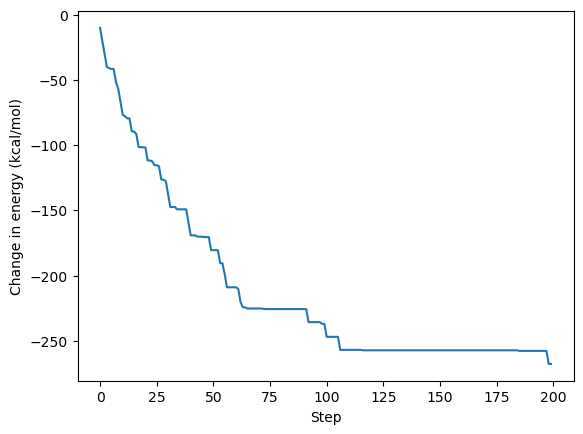

In [5]:
fig, ax = plt.subplots()
ax.plot(np.cumsum(de))

ax.set_xlabel('Step')
ax.set_ylabel('Change in energy (kcal/mol)')
plt.show()